In [1]:
import os
import sys

sys.path.append("..")

import re
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sqlalchemy
from sqlalchemy import func, select, desc
from sqlalchemy.sql.expression import and_, or_

from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection

import config
import cyclops
from cyclops.orm import Database
from cyclops.queries import query_gemini_delirium_diagnosis, query_gemini_delirium_lab
from cyclops.processors.diagnosis_codes import DiagnosisProcessor
from cyclops.processors.column_names import (
    ENCOUNTER_ID,
    DIAGNOSIS_CODE,
    ADMIT_TIMESTAMP,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_TIMESTAMP,
    LAB_TEST_NAME,
    LAB_TEST_RESULT_UNIT,
    REFERENCE_RANGE,
    HOSPITAL_ID,
    AGE,
)
from cyclops.processors.labs import LabsProcessor
from cyclops.processors.feature_handler import FeatureHandler

import cyclops.query_utils as q_utils

import cyclops.query_mimic as qm

%load_ext autoreload
%autoreload 2 # Load when external files are updated
%load_ext nb_black

2022-03-20 14:33:25,605 INFO config          - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-03-20 14:33:25,638 INFO cyclops.utils.profile - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-03-20 14:33:25,639 INFO cyclops.query_utils - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-03-20 14:33:25,641 INFO cyclops.orm     - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-03-20 14:33:25,643 INFO cyclops.processors.base - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-03-20 14:33:25,644 INFO cyclops.processors.diagnosis_codes - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-03-20 14:33:25,646 INFO cyclops.processors.labs - Log file is /home/kmckeen/gemini/cyclops/log.log
2022-03-20 14:33:25,666 INFO cyclops.processors.feature_handler - Log file is /home/kmckeen/gemini/cyclops/log.log


<IPython.core.display.Javascript object>

# Setup ORM

In [2]:
os.environ["USER"] = "postgres"
os.environ["PGPASSWORD"] = "pwd"
cfg = config.read_config("../configs/default/*.yaml")
db = Database(cfg)

2022-03-20 14:33:26,552 INFO cyclops.orm     - Database setup, ready to run queries!


<IPython.core.display.Javascript object>

MIMIC EDA
See sample_code/delirium.ipynb

In sample_code/data_layer.ipynb:
from evidently.dashboard.tabs import DataQualityTab

# Test general querying functions

In [3]:
query = q_utils.drop_attributes(db.mimic_icu.d_items.data, ["itemid"])
db.run_query(query, limit=5)

2022-03-20 14:33:26,592 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,594 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.022072 s


,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,ICU Admission date,ICU Admission date,datetimeevents,ADT,None,Date and time,None,None
1,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
2,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,None,None
3,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,None,None
4,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,None,Text,None,None


<IPython.core.display.Javascript object>

In [4]:
t = db.mimic_hosp.d_icd_diagnoses
query = q_utils.trim_columns(t, "icd_code")
db.run_query(query, limit=5)

2022-03-20 14:33:26,617 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,618 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.004380 s


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


<IPython.core.display.Javascript object>

In [5]:
t_table = db.mimic_icu.d_items.data
t_select = select(t_table)
t_subquery = t_select.subquery()
print("type(t_table)", type(t_table))
print("type(t_select)", type(t_select))
print("type(t_subquery)", type(t_subquery))

type(t_table) <class 'sqlalchemy.sql.schema.Table'>
type(t_select) <class 'sqlalchemy.sql.selectable.Select'>
type(t_subquery) <class 'sqlalchemy.sql.selectable.Subquery'>


<IPython.core.display.Javascript object>

In [6]:
from sqlalchemy.sql.schema import Table
from sqlalchemy.sql.selectable import Select, Subquery
from cyclops.query_utils import QUERY_TYPES, query_params_to_type


@query_params_to_type(Select)
def fn(t, t2=None):
    return t, t2

<IPython.core.display.Javascript object>

In [7]:
t_after, t2_after = fn(t_table, t2=t_select)
print("type(t_after)", type(t_after))
print("type(t2_after)", type(t2_after))

type(t_after) <class 'sqlalchemy.sql.selectable.Select'>
type(t2_after) <class 'sqlalchemy.sql.selectable.Select'>


<IPython.core.display.Javascript object>

In [8]:
t_after, t2_after = fn(t_select, t2=t_table)
print("type(t_after)", type(t_after))
print("type(t2_after)", type(t2_after))

type(t_after) <class 'sqlalchemy.sql.selectable.Select'>
type(t2_after) <class 'sqlalchemy.sql.selectable.Select'>


<IPython.core.display.Javascript object>

In [9]:
# DBTable
query = t
db.run_query(query, limit=2)

2022-03-20 14:33:26,685 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,685 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.004144 s


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor


<IPython.core.display.Javascript object>

In [10]:
# Table
query = t.data
db.run_query(query, limit=2)

2022-03-20 14:33:26,702 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,702 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.002937 s


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor


<IPython.core.display.Javascript object>

In [11]:
# Select
query = select(t.data)
db.run_query(query, limit=2)

2022-03-20 14:33:26,716 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,717 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.002818 s


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor


<IPython.core.display.Javascript object>

In [12]:
# Subquery
query = select(t.data).subquery()
db.run_query(query, limit=2)

2022-03-20 14:33:26,731 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,731 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.002986 s


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor


<IPython.core.display.Javascript object>

In [13]:
subquery = select(db.mimic_hosp.d_icd_diagnoses.data).subquery()
print("type(subquery.c.icd_code)", type(subquery.c.icd_code))
print(subquery.c.icd_code.name)

type(subquery.c.icd_code) <class 'sqlalchemy.sql.schema.Column'>
icd_code


<IPython.core.display.Javascript object>

In [14]:
running_query = db.mimic_hosp.d_icd_diagnoses
db.run_query(running_query, limit=2)

2022-03-20 14:33:26,758 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,758 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.002825 s


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor


<IPython.core.display.Javascript object>

In [15]:
running_query = q_utils.rename_attributes(running_query, {"long_title": "icd_title"})
db.run_query(running_query, limit=2)

2022-03-20 14:33:26,773 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,774 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.003209 s


,icd_code,icd_version,icd_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor


<IPython.core.display.Javascript object>

In [16]:
running_query = q_utils.reorder_attributes(
    running_query, ["icd_version", "icd_code", "icd_title"]
)
db.run_query(running_query, limit=2)

2022-03-20 14:33:26,790 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,791 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.003643 s


,icd_version,icd_code,icd_title
0,9,0010,Cholera due to vibrio cholerae
1,9,0011,Cholera due to vibrio cholerae el tor


<IPython.core.display.Javascript object>

# MIMIC Queries

## Patient Queries

In [17]:
query = qm.patients(db)
db.run_query(query, limit=5)

2022-03-20 14:33:26,810 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,811 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.006632 s


,subject_id,gender,anchor_age,anchor_year,dod,anchor_year_group_start,anchor_year_group_end,year,anchor_year_difference
0,10000048,F,23,2126,None,2008,2010,2009,-117
1,10002723,F,0,2128,None,2017,2019,2018,-110
2,10003939,M,0,2184,None,2008,2010,2009,-175
3,10004222,M,0,2161,None,2014,2016,2015,-146
4,10005325,F,0,2154,None,2011,2013,2012,-142


<IPython.core.display.Javascript object>

## Diagnosis Queries

In [18]:
query = db.mimic_hosp.d_icd_diagnoses
db.run_query(query, limit=5)

2022-03-20 14:33:26,830 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,830 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.005192 s


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


<IPython.core.display.Javascript object>

In [19]:
query = qm.diagnoses(db, version=10)
db.run_query(query, limit=5)

2022-03-20 14:33:26,849 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,850 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.005707 s


,icd_code,icd_title,icd_version
0,B5741,Meningitis in Chagas' disease,10
1,B810,Anisakiasis,10
2,B811,Intestinal capillariasis,10
3,A5489,Other gonococcal infections,10
4,B010,Varicella meningitis,10


<IPython.core.display.Javascript object>

In [20]:
query = qm.patient_diagnoses(db, version=9)
db.run_query(query, limit=5)

2022-03-20 14:33:26,890 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:26,891 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.024787 s


,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_title
0,13940306,23875835,4,9971,9,"Cardiac complications, not elsewhere classified"
1,13940306,23875835,14,3572,9,Polyneuropathy in diabetes
2,13940306,23875835,15,25050,9,"Diabetes with ophthalmic manifestations, type ..."
3,13940306,23875835,5,9980,9,"Postoperative shock, not elsewhere classified"
4,13940306,23875835,6,5990,9,"Urinary tract infection, site not specified"


<IPython.core.display.Javascript object>

In [21]:
query = qm.patient_diagnoses_by_icd_codes(db, 4168)
db.run_query(query, limit=5)

2022-03-20 14:33:27,676 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,677 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.762905 s


,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_title
0,19548143,27281338,10,4168,9,Other chronic pulmonary heart diseases
1,17340686,27589420,17,4168,9,Other chronic pulmonary heart diseases
2,13659848,24610593,11,4168,9,Other chronic pulmonary heart diseases
3,19546784,24086815,12,4168,9,Other chronic pulmonary heart diseases
4,14503234,24114783,8,4168,9,Other chronic pulmonary heart diseases


<IPython.core.display.Javascript object>

In [22]:
query = qm.patient_diagnoses_by_substring(db, "delirium")
db.run_query(query, limit=5)

2022-03-20 14:33:27,755 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,756 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.063625 s


,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_title,icd_title_1
0,14848981,25911532,13,2930,9,Delirium due to conditions classified elsewhere,Delirium due to conditions classified elsewhere
1,16730752,25417321,3,2930,9,Delirium due to conditions classified elsewhere,Delirium due to conditions classified elsewhere
2,13245169,27037380,5,2930,9,Delirium due to conditions classified elsewhere,Delirium due to conditions classified elsewhere
3,13742779,27154382,1,2930,9,Delirium due to conditions classified elsewhere,Delirium due to conditions classified elsewhere
4,15007435,26049411,3,2930,9,Delirium due to conditions classified elsewhere,Delirium due to conditions classified elsewhere


<IPython.core.display.Javascript object>

## Vitals

We need MIMIC-ED: https://physionet.org/content/mimic-iv-ed/1.0/

## Labs

In [23]:
query = select(db.mimic_icu.d_items.data)
db.run_query(query, limit=5)

2022-03-20 14:33:27,780 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,781 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.004594 s


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,None,Date and time,None,None
1,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
2,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,None,None
3,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,None,None
4,220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,None,Text,None,None


<IPython.core.display.Javascript object>

In [24]:
query = qm.event_labels(db, category="Routine Vital Signs")
db.run_query(query, limit=5)

2022-03-20 14:33:27,797 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,798 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.004080 s


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
1,220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,None,Text,NaN,NaN
2,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0
3,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0
4,220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


<IPython.core.display.Javascript object>

In [25]:
query = qm.event_labels_by_substring(db, "sodium")
db.run_query(query, limit=5)

2022-03-20 14:33:27,815 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,816 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.004910 s


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220645,Sodium (serum),Sodium (serum),chartevents,Labs,None,Numeric,None,None
1,220995,Sodium Bicarbonate 8.4%,Sodium Bicarbonate 8.4%,inputevents,Medications,mEq,Solution,None,None
2,221211,"Sodium Bicarbonate 1,4%","NaBic 1,4%",inputevents,Fluids - Other (Not In Use),mL,Solution,None,None
3,225152,Heparin Sodium,Heparin Sodium,inputevents,Medications,units,Solution,None,None
4,225164,Trisodium Citrate 0.4%,Trisodium Citrate 0.4%,inputevents,Fluids/Intake,mL,Solution,None,None


<IPython.core.display.Javascript object>

In [26]:
query = qm.events(db)
db.run_query(query, limit=3)

/home/kmckeen/gemini/cyclops_env/lib/python3.8/site-packages/pandas/io/sql.py:1424: SAWarning: SELECT statement has a cartesian product between FROM element(s) "anon_1" and FROM element "mimic_icu.d_items".  Apply join condition(s) between each element to resolve.
  return self.connectable.execution_options().execute(*args, **kwargs)
2022-03-20 14:33:27,833 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,834 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.006735 s


,subject_id,hadm_id,stay_id,charttime,storetime,value,valuenum,valueuom,warning,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,10567490,23479235,37883727,2146-03-23 21:00:00,2146-03-23 21:21:00,130,130.0,bpm,0,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
1,10567490,23479235,37883727,2146-03-23 21:00:00,2146-03-23 21:21:00,86,86.0,mmHg,0,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
2,10567490,23479235,37883727,2146-03-23 21:00:00,2146-03-23 21:21:00,60,60.0,mmHg,0,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None


<IPython.core.display.Javascript object>

In [27]:
query = qm.events_by_itemids(db, 223876)
db.run_query(query, limit=5)

/home/kmckeen/gemini/cyclops_env/lib/python3.8/site-packages/pandas/io/sql.py:1424: SAWarning: SELECT statement has a cartesian product between FROM element(s) "anon_2" and FROM element "mimic_icu.d_items".  Apply join condition(s) between each element to resolve.
  return self.connectable.execution_options().execute(*args, **kwargs)
2022-03-20 14:33:27,858 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,859 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.007180 s


,subject_id,hadm_id,stay_id,charttime,storetime,value,valuenum,valueuom,warning,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,88,88.0,bpm,0,223876,Apnea Interval,Apnea Interval,chartevents,Respiratory,sec,Numeric,None,None
1,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,96,96.0,%,0,223876,Apnea Interval,Apnea Interval,chartevents,Respiratory,sec,Numeric,None,None
2,10568559,25084776,35376336,2111-11-21 14:15:00,2111-11-21 14:16:00,84,84.0,bpm,0,223876,Apnea Interval,Apnea Interval,chartevents,Respiratory,sec,Numeric,None,None
3,10568559,25084776,35376336,2111-11-21 14:15:00,2111-11-21 14:16:00,97,97.0,%,0,223876,Apnea Interval,Apnea Interval,chartevents,Respiratory,sec,Numeric,None,None
4,10568559,25084776,35376336,2111-11-21 14:16:00,2111-11-21 14:55:00,104,104.0,mmHg,0,223876,Apnea Interval,Apnea Interval,chartevents,Respiratory,sec,Numeric,None,None


<IPython.core.display.Javascript object>

In [28]:
query = qm.events_by_itemids(db, [223873, 223875])
db.run_query(query, limit=5)

2022-03-20 14:33:27,883 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,883 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.005832 s


,subject_id,hadm_id,stay_id,charttime,storetime,value,valuenum,valueuom,warning,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,88,88.0,bpm,0,223873,Paw High,Paw High,chartevents,Respiratory,cmH2O,Numeric,None,None
1,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,96,96.0,%,0,223873,Paw High,Paw High,chartevents,Respiratory,cmH2O,Numeric,None,None
2,10568559,25084776,35376336,2111-11-21 14:15:00,2111-11-21 14:16:00,84,84.0,bpm,0,223873,Paw High,Paw High,chartevents,Respiratory,cmH2O,Numeric,None,None
3,10568559,25084776,35376336,2111-11-21 14:15:00,2111-11-21 14:16:00,97,97.0,%,0,223873,Paw High,Paw High,chartevents,Respiratory,cmH2O,Numeric,None,None
4,10568559,25084776,35376336,2111-11-21 14:16:00,2111-11-21 14:55:00,104,104.0,mmHg,0,223873,Paw High,Paw High,chartevents,Respiratory,cmH2O,Numeric,None,None


<IPython.core.display.Javascript object>

In [29]:
query = qm.events_by_labels(db, ["Paw High"])
db.run_query(query, limit=5)

/home/kmckeen/gemini/cyclops_env/lib/python3.8/site-packages/pandas/io/sql.py:1424: SAWarning: SELECT statement has a cartesian product between FROM element(s) "anon_2" and FROM element "mimic_icu.d_items".  Apply join condition(s) between each element to resolve.
  return self.connectable.execution_options().execute(*args, **kwargs)
2022-03-20 14:33:27,908 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,909 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.008967 s


,subject_id,hadm_id,stay_id,charttime,storetime,value,valuenum,valueuom,warning,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,88,88.0,bpm,0,223873,Paw High,Paw High,chartevents,Respiratory,cmH2O,Numeric,None,None
1,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,96,96.0,%,0,223873,Paw High,Paw High,chartevents,Respiratory,cmH2O,Numeric,None,None
2,10568559,25084776,35376336,2111-11-21 14:15:00,2111-11-21 14:16:00,84,84.0,bpm,0,223873,Paw High,Paw High,chartevents,Respiratory,cmH2O,Numeric,None,None
3,10568559,25084776,35376336,2111-11-21 14:15:00,2111-11-21 14:16:00,97,97.0,%,0,223873,Paw High,Paw High,chartevents,Respiratory,cmH2O,Numeric,None,None
4,10568559,25084776,35376336,2111-11-21 14:16:00,2111-11-21 14:55:00,104,104.0,mmHg,0,223873,Paw High,Paw High,chartevents,Respiratory,cmH2O,Numeric,None,None


<IPython.core.display.Javascript object>

In [30]:
query = qm.events_by_label_substring(db, "heart")
db.run_query(query, limit=5)

/home/kmckeen/gemini/cyclops_env/lib/python3.8/site-packages/pandas/io/sql.py:1424: SAWarning: SELECT statement has a cartesian product between FROM element(s) "anon_2" and FROM element "mimic_icu.d_items".  Apply join condition(s) between each element to resolve.
  return self.connectable.execution_options().execute(*args, **kwargs)
2022-03-20 14:33:27,932 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,933 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.005633 s


,subject_id,hadm_id,stay_id,charttime,storetime,value,valuenum,valueuom,warning,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,88,88.0,bpm,0,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
1,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,96,96.0,%,0,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
2,10568559,25084776,35376336,2111-11-21 14:15:00,2111-11-21 14:16:00,84,84.0,bpm,0,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
3,10568559,25084776,35376336,2111-11-21 14:15:00,2111-11-21 14:16:00,97,97.0,%,0,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
4,10568559,25084776,35376336,2111-11-21 14:16:00,2111-11-21 14:55:00,104,104.0,mmHg,0,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None


<IPython.core.display.Javascript object>

In [31]:
db.run_query(db.mimic_icu.chartevents, limit=5)

2022-03-20 14:33:27,951 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,952 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.003581 s


,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,220045,88,88.0,bpm,0
1,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,220277,96,96.0,%,0
2,10568559,25084776,35376336,2111-11-21 14:15:00,2111-11-21 14:16:00,220045,84,84.0,bpm,0
3,10568559,25084776,35376336,2111-11-21 14:15:00,2111-11-21 14:16:00,220277,97,97.0,%,0
4,10568559,25084776,35376336,2111-11-21 14:16:00,2111-11-21 14:55:00,220179,104,104.0,mmHg,0


<IPython.core.display.Javascript object>

In [32]:
db.run_query(db.mimic_icu.d_items.data, limit=5)

2022-03-20 14:33:27,966 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,967 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.003043 s


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,None,Date and time,None,None
1,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
2,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,None,None
3,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,None,None
4,220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,None,Text,None,None


<IPython.core.display.Javascript object>

In [33]:
query = qm.events(db, category="Routine Vital Signs")
db.run_query(query, limit=3)

/home/kmckeen/gemini/cyclops_env/lib/python3.8/site-packages/pandas/io/sql.py:1424: SAWarning: SELECT statement has a cartesian product between FROM element(s) "anon_1" and FROM element "mimic_icu.d_items".  Apply join condition(s) between each element to resolve.
  return self.connectable.execution_options().execute(*args, **kwargs)
2022-03-20 14:33:27,991 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:27,992 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.009385 s


,subject_id,hadm_id,stay_id,charttime,storetime,value,valuenum,valueuom,warning,category,itemid,label,abbreviation,linksto,category_1,unitname,param_type,lownormalvalue,highnormalvalue
0,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,88,88.0,bpm,0,Routine Vital Signs,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
1,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,88,88.0,bpm,0,Routine Vital Signs,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None
2,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,88,88.0,bpm,0,Routine Vital Signs,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,None,None


<IPython.core.display.Javascript object>

In [34]:
query = qm.events(db, category="Respiratory")
db.run_query(query, limit=3)

2022-03-20 14:33:28,028 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:28,029 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.014302 s


,subject_id,hadm_id,stay_id,charttime,storetime,value,valuenum,valueuom,warning,category,itemid,label,abbreviation,linksto,category_1,unitname,param_type,lownormalvalue,highnormalvalue
0,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,96,96.0,%,0,Respiratory,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,None,None
1,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,96,96.0,%,0,Respiratory,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,None,None
2,10568559,25084776,35376336,2111-11-21 14:00:00,2111-11-21 14:15:00,96,96.0,%,0,Respiratory,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,None,None


<IPython.core.display.Javascript object>

2022-03-20 14:33:28,077 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:28,077 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.013557 s


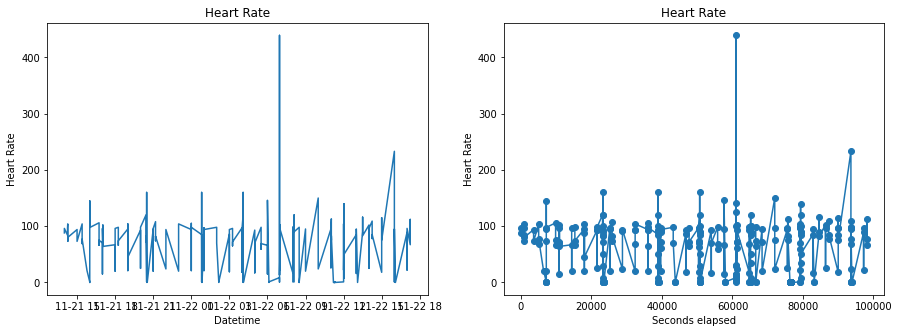

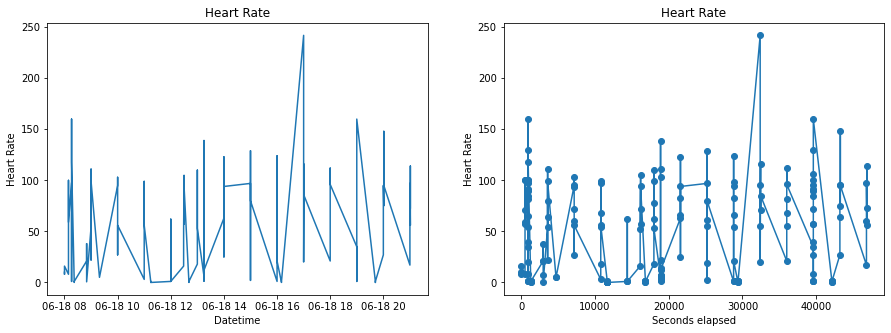

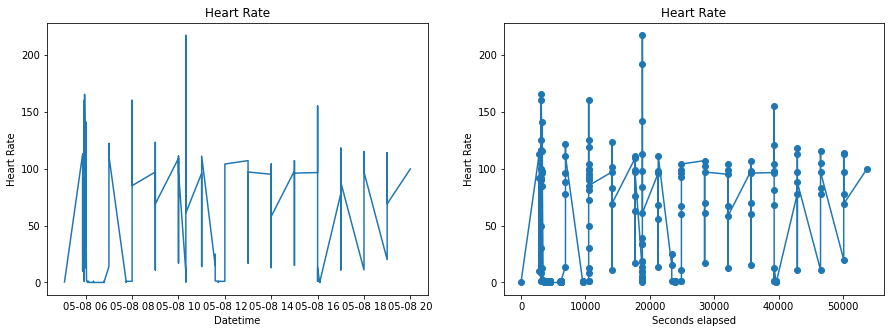

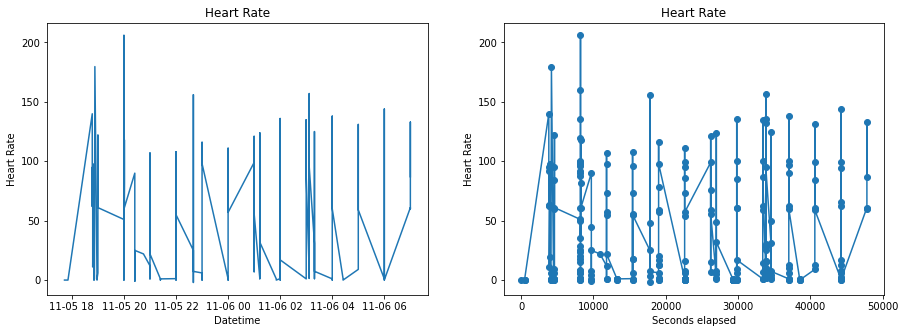

<IPython.core.display.Javascript object>

In [35]:
from datetime import datetime

# Get heart rate
query = qm.events_by_labels(db, "Heart Rate")
df = db.run_query(query, limit=1000)

# Get only the labs with numeric value - This is just for now
# realistically we can find ways to utilize the other data!
df = df[df["valuenum"].notna()]

# Convert to datetime
df["charttime"] = pd.to_datetime(df["charttime"])

# Group by patient (subject_id), admission (hadm_id), ICU stay (stay_id), and event (itemid)
# NOTE: We may or may not want to group by hadm_id and/or stay_id
groupby = df.groupby(["subject_id", "hadm_id", "stay_id", "itemid"])

c = 0
for name, group in groupby:
    group.sort_values(by="charttime", inplace=True)

    label = group["label"].iloc[0]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title(label)
    ax[0].plot(group["charttime"], group["valuenum"])
    ax[0].set_ylabel(label)
    ax[0].set_xlabel("Datetime")

    # Convert dates to seconds elapsed since first measurement
    group["charttime"] = (group["charttime"] - datetime.now()).dt.total_seconds()
    group["charttime"] -= group["charttime"].min()

    ax[1].set_title(label)
    ax[1].plot(group["charttime"], group["valuenum"])
    ax[1].scatter(group["charttime"], group["valuenum"])
    ax[1].set_ylabel(label)
    ax[1].set_xlabel("Seconds elapsed")
    c += 1
    if c > 10:
        break

# Feature extraction

## Target extraction

In [36]:
query = qm.patient_diagnoses(db, include_icd_title=True)
db.run_query(query, limit=10)

2022-03-20 14:33:29,108 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:29,109 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.308966 s


,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_title
0,17797080,20122993,5,V1254,9,Personal history of transient ischemic attack ...
1,19219256,21658361,8,5859,9,"Chronic kidney disease, unspecified"
2,19219256,21658361,4,30590,9,"Other, mixed, or unspecified drug abuse, unspe..."
3,19219256,21658361,7,E8499,9,Accidents occurring in unspecified place
4,19219256,21658361,5,29284,9,Drug-induced mood disorder
5,19219256,21658361,2,78650,9,"Chest pain, unspecified"
6,12256892,21861018,1,78650,9,"Chest pain, unspecified"
7,18862737,22755173,4,2767,9,Hyperpotassemia
8,15534630,29323706,1,56981,9,"Fistula of intestine, excluding rectum and anus"
9,10260488,28548228,2,7847,9,Epistaxis


<IPython.core.display.Javascript object>

In [37]:
# Get all patient diagnoses with substring delirium
subquery = qm.patient_diagnoses_by_substring(db, "delirium").subquery()

# Include patient statics
query = qm.join_with_patients(db, subquery)

# Run the query
delirium_codes_df = db.run_query(query)
delirium_codes_df

2022-03-20 14:33:29,842 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:29,843 INFO cyclops.utils.profile - Finished executing function wrapper_func in 0.702928 s


,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_title,icd_title_1,subject_id_1,gender,anchor_age,anchor_year,dod,anchor_year_group_start,anchor_year_group_end,year,anchor_year_difference
0,10899225,23397839,4,29281,9,Drug-induced delirium,Drug-induced delirium,10899225,M,70,2146,None,2011,2013,2012,-134
1,10076543,24519254,4,2930,9,Delirium due to conditions classified elsewhere,Delirium due to conditions classified elsewhere,10076543,F,78,2187,None,2008,2010,2009,-178
2,10148710,22444443,4,F05,10,Delirium due to known physiological condition,Delirium due to known physiological condition,10148710,M,67,2137,None,2008,2010,2009,-128
3,10700130,27230471,2,2930,9,Delirium due to conditions classified elsewhere,Delirium due to conditions classified elsewhere,10700130,F,91,2198,None,2008,2010,2009,-189
4,11239965,21679320,3,F05,10,Delirium due to known physiological condition,Delirium due to known physiological condition,11239965,M,42,2131,None,2014,2016,2015,-116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9082,19999068,21606769,1,2910,9,Alcohol withdrawal delirium,Alcohol withdrawal delirium,19999068,M,63,2161,None,2011,2013,2012,-149
9083,19970491,22119205,3,2910,9,Alcohol withdrawal delirium,Alcohol withdrawal delirium,19970491,M,55,2129,None,2008,2010,2009,-120
9084,19999068,21606769,10,29281,9,Drug-induced delirium,Drug-induced delirium,19999068,M,63,2161,None,2011,2013,2012,-149
9085,19972371,29626339,3,2930,9,Delirium due to conditions classified elsewhere,Delirium due to conditions classified elsewhere,19972371,F,69,2154,None,2011,2013,2012,-142


<IPython.core.display.Javascript object>

In [38]:
# Get matrix of pat2 ient IDs, hadm (hospital stay) IDs
# of people diagnosed with delirium. These people will
# be the ones with label 1 in the final target matrix
target_df = delirium_codes_df[["subject_id", "hadm_id"]].drop_duplicates().to_numpy()
target_df

array([[10899225, 23397839],
       [10076543, 24519254],
       [10148710, 22444443],
       ...,
       [19970491, 22119205],
       [19972371, 29626339],
       [19973306, 24844065]])

<IPython.core.display.Javascript object>

## Input extraction

In [39]:
from cyclops.processors.column_names import ENCOUNTER_ID, DIAGNOSIS_CODE

<IPython.core.display.Javascript object>

In [40]:
subquery = qm.patient_diagnoses(db, version=10, include_icd_title=False).subquery()
query = q_utils.rename_attributes(
    subquery, {"hadm_id": ENCOUNTER_ID, "icd_code": DIAGNOSIS_CODE}
)
data = db.run_query(query)
data

2022-03-20 14:33:35,753 INFO cyclops.orm     - Query returned successfully!
2022-03-20 14:33:35,754 INFO cyclops.utils.profile - Finished executing function wrapper_func in 5.869666 s


,subject_id,encounter_id,seq_num,diagnosis_code,icd_version
0,18335503,21596415,2,E861,10
1,18335503,21596415,5,O99512,10
2,18335503,21596415,6,J45909,10
3,18335503,21596415,1,O99612,10
4,18335503,21596415,7,O99282,10
...,...,...,...,...,...
2189976,12456798,23802536,2,K5190,10
2189977,12456798,23802536,1,Z432,10
2189978,12456798,23802536,3,K913,10
2189979,16638799,23568999,3,D500,10


<IPython.core.display.Javascript object>

In [41]:
must_have_columns = [ENCOUNTER_ID, DIAGNOSIS_CODE]
data_diagnosis = data[must_have_columns]

diagnosis_processor = DiagnosisProcessor(data_diagnosis, must_have_columns)
diagnosis_features = diagnosis_processor.process()
diagnosis_features

2022-03-20 14:33:35,854 INFO cyclops.processors.base - Processing raw diagnosis codes...
2022-03-20 14:33:35,871 INFO cyclops.processors.base - # samples: 2189981, # encounters: 185743
2022-03-20 14:34:38,738 INFO cyclops.processors.base - Converting diagnosis codes to ICD codes...
2022-03-20 14:34:38,755 INFO cyclops.processors.base - # samples: 2189981, # encounters: 185743
2022-03-20 14:34:38,879 INFO cyclops.processors.diagnosis_codes - # diagnosis features: 22, # encounters: 185743
2022-03-20 14:36:09,255 INFO cyclops.utils.profile - Finished executing function process in 153.400184 s


,E00_E89,O00_O99,J00_J99,R00_R99,A00_B99,,Z00_Z99,P00_P96,N00_N99,G00_G99,...,D50_D89,F01_F99,L00_L99,C00_D49,V00_Y99,K00_K95,H00_H59,S00_T88,Q00_Q99,H60_H95
21596415,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27862869,0,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
20659410,0,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21283853,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20789372,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22218090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23571962,1,0,1,1,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
29716163,0,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,1,0,0,0,0
20629285,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

## Get Delirium Target

In [42]:
target_query = patient_diagnoses_by_substring("delirium").subquery()

query = select(target_query, patient_anchors).where(
    target_query.c.subject_id == patient_anchors.c.subject_id
)

target_df = db.run_query(query)

# Get matrix of patient IDs, hadm (hospital stay) IDs
sub_hadm_target = target_df[["subject_id", "hadm_id"]].drop_duplicates().to_numpy()
sub_hadm_target

NameError: name 'patient_diagnoses_by_substring' is not defined

<IPython.core.display.Javascript object>

In [ ]:
sub_hadm_target.shape

In [ ]:
# Check to make sure none of the codes overlap with the delirium codes
target_set = set(target_df['icd_code'].values)
features_set = set(feature_codes)
assert len(target_set.intersection(features_set)) == 0

## Get Features

In [ ]:
from cyclops.processors.feature_handler import FeatureHandler

### Baseline handling class

In [ ]:
# Keep in here for now

from sklearn.model_selection import train_test_split


# Regression
from sklearn.linear_model import LinearRegression


# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC


# Both
from sklearn.neural_network import MLPClassifier


class BaselineHandler:
    def __init__(self, feature_handler):
        self.fh = feature_handler
        
    
    def run(self, verbose=True):
        features = self.fh.features_scaled
        targets = self.fh.targets_scaled

        X = features.values
        y_all = targets.values
        target_types = np.array(fh.types)[np.array(fh.is_target)]
        target_names = np.array(fh.names)[np.array(fh.is_target)]
        
        X_train, X_val, y_train_all, y_val_all = train_test_split( \
            X, y_all, test_size=0.2, shuffle=True)
        
        for i in range(len(targets.columns)):
            y_train = y_train_all[:, i]
            y_val = y_val_all[:, i]
            target_type = target_types[i]
            target_name = target_names[i]
            
            if verbose:
                print("===", target_name, "===")

            if target_type == 'binary':
                for Model in [LogisticRegression, SVC, LinearSVC, MLPClassifier]:
                    model = Model()
                    model.fit(X_train, y_train)
                    
                    if verbose:
                        print(type(model).__name__ , ":", model.score(X_val, y_val))
            
            if target_type == 'numeric':
                for Model in [LinearRegression, MLPClassifier]:
                    model = Model()
                    model.fit(X_train, y_train)
                    
                    if verbose:
                        print(type(model).__name__ , ":", model.score(X_val, y_val))
                

In [ ]:
arr_numeric = np.array([[1.5, 5.2, 10], [23, 10.4, 9], [3.9, 15.1, 8], [4.9, 20, 7], [5, 25.5, 6]])
arr_numeric_string = np.array([["1"], ["2"], ["3"], ["4"], ["5"]])
arr_features = np.concatenate([arr_numeric, arr_numeric_string], axis=1)

arr_targets = np.array([1, 0, 1, 1, 0])

fh = FeatureHandler()
fh.add_features(arr_features)
fh.add_features(arr_targets, is_target=True)

In [ ]:
fh.df_unscaled

In [ ]:
bh = BaselineHandler(fh)
bh.run()

## Binary ICD features

In [ ]:
icd_feature_query = patient_diagnoses_by_icd_codes(feature_codes, version='10').subquery()

query = select(icd_feature_query, patient_anchors).where( \
    icd_feature_query.c.subject_id == patient_anchors.c.subject_id)

features_df = db.run_query(query)
features_df

In [ ]:
features_df = features_df[[
    'subject_id',
    'hadm_id',
    'icd_code',
    'gender',
    'anchor_age',
    'anchor_year',
    'year'
]]

In [ ]:
# Group the data by patients and their hospital visits
features_df_grouped = features_df.groupby(["subject_id", "hadm_id"])

# USE A GROUPBY APPLY INSTEAD OF THIS
features_binary = np.zeros((len(features_df_grouped), len(categories_distinct)))
sub_hadm_features = np.zeros((len(features_df_grouped), 2), dtype=np.int64)
count = 0
for key, item in features_df_grouped:
    vals = item.icd_code.str.strip().values
    groups = np.unique(code_to_category_vec(vals))
    sub_hadm_features[count] = list(key)
    features_binary[count][category_to_index_vec(groups)] = 1
    count += 1

In [ ]:
# Get counts from each feature
counts = features_binary.sum(axis=0)
for i, c in enumerate(categories_distinct):
    print(c, "count:", counts[i])

### Static Features

In [ ]:
grouped_firsts = features_df_grouped.first().reset_index()
static_feature_names = np.array(['gender', 'anchor_age'])
static_features = grouped_firsts[static_feature_names].to_numpy()
static_features.shape

In [ ]:
static_features[0, :]

In [ ]:
features = FeatureHandler()

In [ ]:
features.add_features(features_binary, names=categories_distinct)

In [ ]:
features.add_features(static_features, names=static_feature_names)

In [ ]:
features.names

### AGE BROKEN - FIX

NOTE: I still think some of the ages shouldn't be 0 when they are.

This age doesn't actually correspond to the hospital visit... need to sort this out. Where is the approx year in the hospital table?

Get target

In [ ]:
def multidim_intersect(arr1, arr2):
    intersected = set(map(tuple, arr1)).intersection(set(map(tuple, arr2)))  
    return np.array(list(intersected))

# Find common patient/visit between target and features
inters = multidim_intersect(sub_hadm_features, sub_hadm_target)
inds = np.where((sub_hadm_features == inters[:,None]).all(-1))[1]

## Dataset Prep

In [ ]:
f = features.df_scaled.values

In [ ]:
# Get samples with the target being true
features_with_target = f[inds]

# Get samples with the target being false
mask = np.ones(f.shape[0], dtype=bool)
mask[inds] = False
features_without_target = f[mask]

# Take the minimum number of samples from each
num = min([features_with_target.shape[0], features_without_target.shape[0]])

print(features_with_target.shape)
print(features_without_target.shape)

features_with_target = features_with_target[:num]
features_without_target = features_without_target[:num]
X = np.concatenate([features_with_target, features_without_target])
y = np.zeros(2*num, dtype=bool)
y[:num] = 1

Oversampling /Undersampling
Oversampling class with fewer, undersample class with more
Sklearn - class balance
Resamples the dataset such that, in a batch, you'll have roughly the same number per batch

Metrics: Precision, recall, F1, accuracy, confusion matrix, ROC curve/aROC
Trade off: No balancing = predict 0s only,

Sensitivity vs. Specificity

Create a couple functions (using sklearn resample)
Undersampling only, oversampling only, both, etc.


Class weighting - weight loss according to class balance? Later on perhaps

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( \
    X, y, test_size=0.33, shuffle=True, random_state=42)

#X_test, X_val, y_test, y_val = train_test_split( \
#    X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

# Evaluative Metrics

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc_curve(model):
    # predict probabilities
    yhat = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(testy, yhat)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')

    # Plot
    plt.datalabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

#model.score
#model.predict_proba

# Baselines

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

In [ ]:
# Get coefficients
coef = reg.coef_[0]
# summarize feature importance
for i,v in enumerate(coef):
	print("{} score: {}".format(features.names[i], np.round(v,3)))
# plot feature importance
plt.bar([x for x in range(len(coef))], coef)
plt.show()

## SVM

Try using min-max normalization vs standardization to see difference in results

Add None, 'standardize', 'min-max' as options for standardization

### Non-linear

In [ ]:
from sklearn.svm import SVC

svc = SVC(tol=1e-5)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

### Linear

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC(tol=1e-5)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

In [ ]:
# Get coefficients
coef = svc.coef_[0]
# summarize feature importance
for i,v in enumerate(coef):
	print("{} score: {}".format(features.names[i], np.round(v,3)))
# plot feature importance
plt.bar([x for x in range(len(coef))], coef)
plt.show()

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation="relu",
    alpha=0.001,
    learning_rate="adaptive",
    max_iter=500,
    validation_fraction=0.2,
    early_stopping=True,
)

acc = []
for train_indices, test_indices in kf.split(X_train):
    clf.fit(X_train[train_indices], y_train[train_indices])
    acc.append(clf.score(X_train[test_indices], y_train[test_indices]))
    print("Train loss:", clf.loss_)
    print("Val acc:", acc[-1])


# mlp.fit(X, y)
# plt.plot(mlp.loss_curve_, color='blue')
# plt.plot(mlp.validation_scores_, color='orange')

# print("Train Acc:", mlp.score_)
# print("Val Acc:", best_validation_score_)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.001, max_iter=500)
mlp.fit(X_train, y_train)
plt.plot(mlp.loss_curve_)

print("Train Acc:", mlp.score(X_train, y_train))

y_train_pred = mlp.predict_proba(X_train)
train_acc = (np.argmax(y_train_pred, axis=1) == y_train).sum()/y_train.shape[0]
print("Train Acc:", train_acc)

y_test_pred = mlp.predict_proba(X_test)
test_acc = (np.argmax(y_test_pred, axis=1) == y_test).sum()/y_test.shape[0]
print("Test Acc:", test_acc)

This is a decently high accuracy... maybe just check to make sure none of the ICD codes we're using are any of the target values? Just as a sanity check!

Write function to find intersection of target ICD codes and feature ICD codes

Label leaking: Some feature which encodes something about the output we wouldn't actually have in the wild - it's cheating


Start to check out the lab data and think of adding features from it

Dealing with NaNs, remove for now
Impute? Imputations methods - a project later on, for sure!

For vitals data, nearest neighbours type of thing
Aggregate over multiple tests, potentially



# Feature Store

Introduction: https://docs.feast.dev/

Quickstart: https://docs.feast.dev/getting-started/quickstart

Quickstart Colab: https://colab.research.google.com/github/feast-dev/feast/blob/master/examples/quickstart/quickstart.ipynb

Feature Repository: https://docs.feast.dev/reference/feature-repository



In [ ]:
%%sh
pip install wheel
pip install feast -U -q
pip install Pygments -q
echo "Please restart your runtime now (Runtime -> Restart runtime). This ensures that the correct dependencies are loaded."

In [ ]:
!feast init feature_repo

In [ ]:
%cd feature_repo
!ls -R

In [ ]:
!pygmentize feature_store.yaml

In [ ]:
import pandas as pd
pd.read_parquet("data/driver_stats.parquet")

In [ ]:
!pygmentize -f terminal16m example.py

In [ ]:
!feast apply

In [ ]:
from datetime import datetime, timedelta
import pandas as pd

from feast import FeatureStore

# The entity dataframe is the dataframe we want to enrich with feature values
entity_df = pd.DataFrame.from_dict(
    {
        "driver_id": [1001, 1002, 1003],
        "label_driver_reported_satisfaction": [1, 5, 3], 
        "event_timestamp": [
            datetime.now() - timedelta(minutes=11),
            datetime.now() - timedelta(minutes=36),
            datetime.now() - timedelta(minutes=73),
        ],
    }
)

store = FeatureStore(repo_path=".")

training_df = store.get_historical_features(
    entity_df=entity_df,
    features=[
        "driver_hourly_stats:conv_rate",
        "driver_hourly_stats:acc_rate",
        "driver_hourly_stats:avg_daily_trips",
    ],
).to_df()

print("----- Feature schema -----\n")
print(training_df.info())

print()
print("----- Example features -----\n")
print(training_df.head())

In [ ]:
from datetime import datetime
!feast materialize-incremental {datetime.now().isoformat()}

In [ ]:
print("--- Data directory ---")
!ls data

import sqlite3
import pandas as pd
con = sqlite3.connect("data/online_store.db")
print("\n--- Schema of online store ---")
print(
    pd.read_sql_query(
        "SELECT * FROM feature_repo_driver_hourly_stats", con).columns.tolist())
con.close()

In [ ]:
from pprint import pprint
from feast import FeatureStore

store = FeatureStore(repo_path=".")

feature_vector = store.get_online_features(
    features=[
        "driver_hourly_stats:conv_rate",
        "driver_hourly_stats:acc_rate",
        "driver_hourly_stats:avg_daily_trips",
    ],
    entity_rows=[
        {"driver_id": 1004},
        {"driver_id": 1005},
    ],
).to_dict()

pprint(feature_vector)